# <center>Inteligencia de Negocios</center>
### <center>Clasificación de uvas</center>

## Alumnos
- Angeles Rodriguez Ilan
- Loma Aguirre Mariesther

## Docente
- Dr. Daza Vergaray Alfredo

# <center>Importar Modulos Necesarios</center>

In [32]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


<a id="concept"></a>
# <center>Concepto de Callback Personalizado</center>
Este notebook implementa un callback personalizado para ajustar la tasa de aprendizaje durante el entrenamiento. El callback tiene un parámetro llamado "dwell". Si "dwell" está configurado en True, el callback monitorea la pérdida de validación. Mantiene un registro de la pérdida de validación más baja lograda hasta el momento mientras se ejecuta cada época y la almacena como la pérdida más baja, además de almacenar los pesos de esa época como los mejores pesos. Al final de una época, la pérdida de validación de esa época se compara con la pérdida más baja. Si la pérdida de validación al final de la época actual es menor que la pérdida más baja, entonces esta se convierte en la pérdida más baja y los pesos de la época actual se convierten en los mejores pesos.

Si la pérdida de validación al final de la época actual es mayor que la pérdida más baja, esto implica que te has movido a una ubicación en el espacio N (N es el número de parámetros entrenables en la superficie de la función de costo de validación) que es menos favorable (mayor costo) que la posición en el espacio N definida por los mejores pesos. Por lo tanto, ¿por qué mover los pesos del modelo a esta ubicación menos favorable? Es mejor restablecer los pesos del modelo a los mejores pesos, luego bajar la tasa de aprendizaje y ejecutar más épocas. La nueva tasa de aprendizaje se establece en new_lr = current_lr * factor, donde factor es un parámetro especificado por el usuario en la instanciación del callback. Por defecto, está configurado en 0.04 y por defecto "dwell" está configurado en True.

Al final del entrenamiento, el callback siempre devuelve tu modelo con los pesos configurados en los mejores pesos. El callback proporciona una función donde periódicamente consulta al usuario para continuar y, opcionalmente, especificar manualmente una nueva tasa de aprendizaje o detener el entrenamiento. Durante el entrenamiento, el callback proporciona información útil sobre el porcentaje de mejora en la pérdida de validación para cada época. Esto es útil para decidir cuándo detener el entrenamiento o especificar manualmente una nueva tasa de aprendizaje.  

<a id="pc"></a>

<a id="pc"></a>
## <center>Definicion de función para imprimir texto en colores RGB especificados para el primer plano y el fondo</center>
La forma de la llamada es:  print_in_color(txt_msg, fore_tupple, back_tupple) donde:
* Es la cadena de texto a imprimir
* fore_tuple es una tupla de la forma (r,g,b) que especifica el color del primer plano del texto
* back_tuple es una tupla de la forma (r,g,b) que especifica el color de fondo del texto

In [33]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="pcounts"></a>
## <center>Función que grafica los valores para una columna en un dataframe</center>

In [34]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    plt.figure(figsize=(20,5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25} 
    plt.bar(labels, values)
    plt.title('Images per label', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

<a id="makedf"></a>
# <center>Lectura de los datos y creacion de los dataframes de entrenamiento </center>

In [35]:
def make_dataframes(train_dir,test_dir, val_dir):
    bad_images=[]
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test'] 
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=plt.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    print (fpath, ' is an invalid image file')
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None:
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None:
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else : # create a  validation dataframe
                pdf=df
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=100, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

test_dir = r'../input/grapesdevelopmentstages/GrapesDevelopmentStages/v0.1/Classification/test'
val_dir= r'../input/grapesdevelopmentstages/GrapesDevelopmentStages/v0.1/Classification/validation' # if there is no validation directory set val_dir = None, a valid_df dataframe will be created from train_df
train_dir= r'../input/grapesdevelopmentstages/GrapesDevelopmentStages/v0.1/Classification/train' # if there is no test directory set test_dir = None, a test_df dataframe will be created from train_df

train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir,test_dir, val_dir)

valid -79                       : 100%|███████████████████████████████████████████████████████| 93/93 [00:00<00:00, 505.86files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  701   the minimum files in any class in train_df is  426
train_df length:  2340   test_df length:  731   valid_df length:  337
average image height=  158   average image width=  165  aspect ratio h/w=  0.9575757575757575


### Número de muestras de imagen para cada etiqueta.

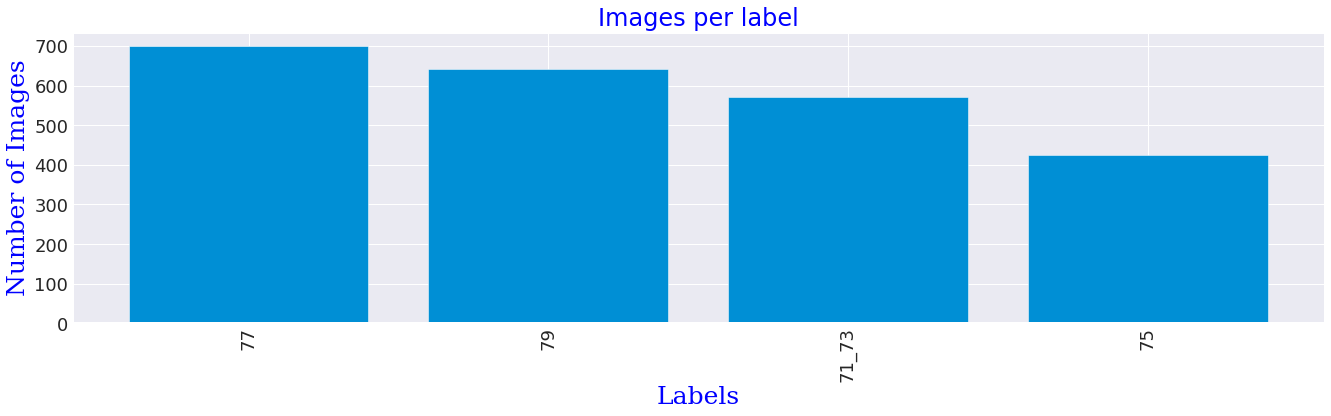

In [36]:
if len(train_df['labels'].unique())<20: # Over 20 labels the plot is to hard to understand
    plot_label_count (train_df, 'labels')

<a id="trim"></a>
## <center>Recortar train_df para que ninguna clase tenga más de 400 imágenes. </center>


In [37]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=400
min_samples=400
column='labels'
train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  2340  with  4  classes
after trimming, the maximum samples in any class is now  400  and the minimum samples in any class is  400
the trimmed dataframe now is of length  1600  with  4  classes


<a id="generators"></a>
# <center>Crear train_gen, test_gen final_test_gen and valid_gen</center>

In [40]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps




In [41]:
img_size=(145, 145)
batch_size=20
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 1600 validated image filenames belonging to 4 classes.           for train generator 
Found 337 validated image filenames belonging to 4 classes.            for valid generator 
Found 731 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  43   test steps:  17  number of classes :  4


<a id="show"></a>
# <center>Crear una función para mostrar ejemplos de imágenes de entrenamiento.</center>

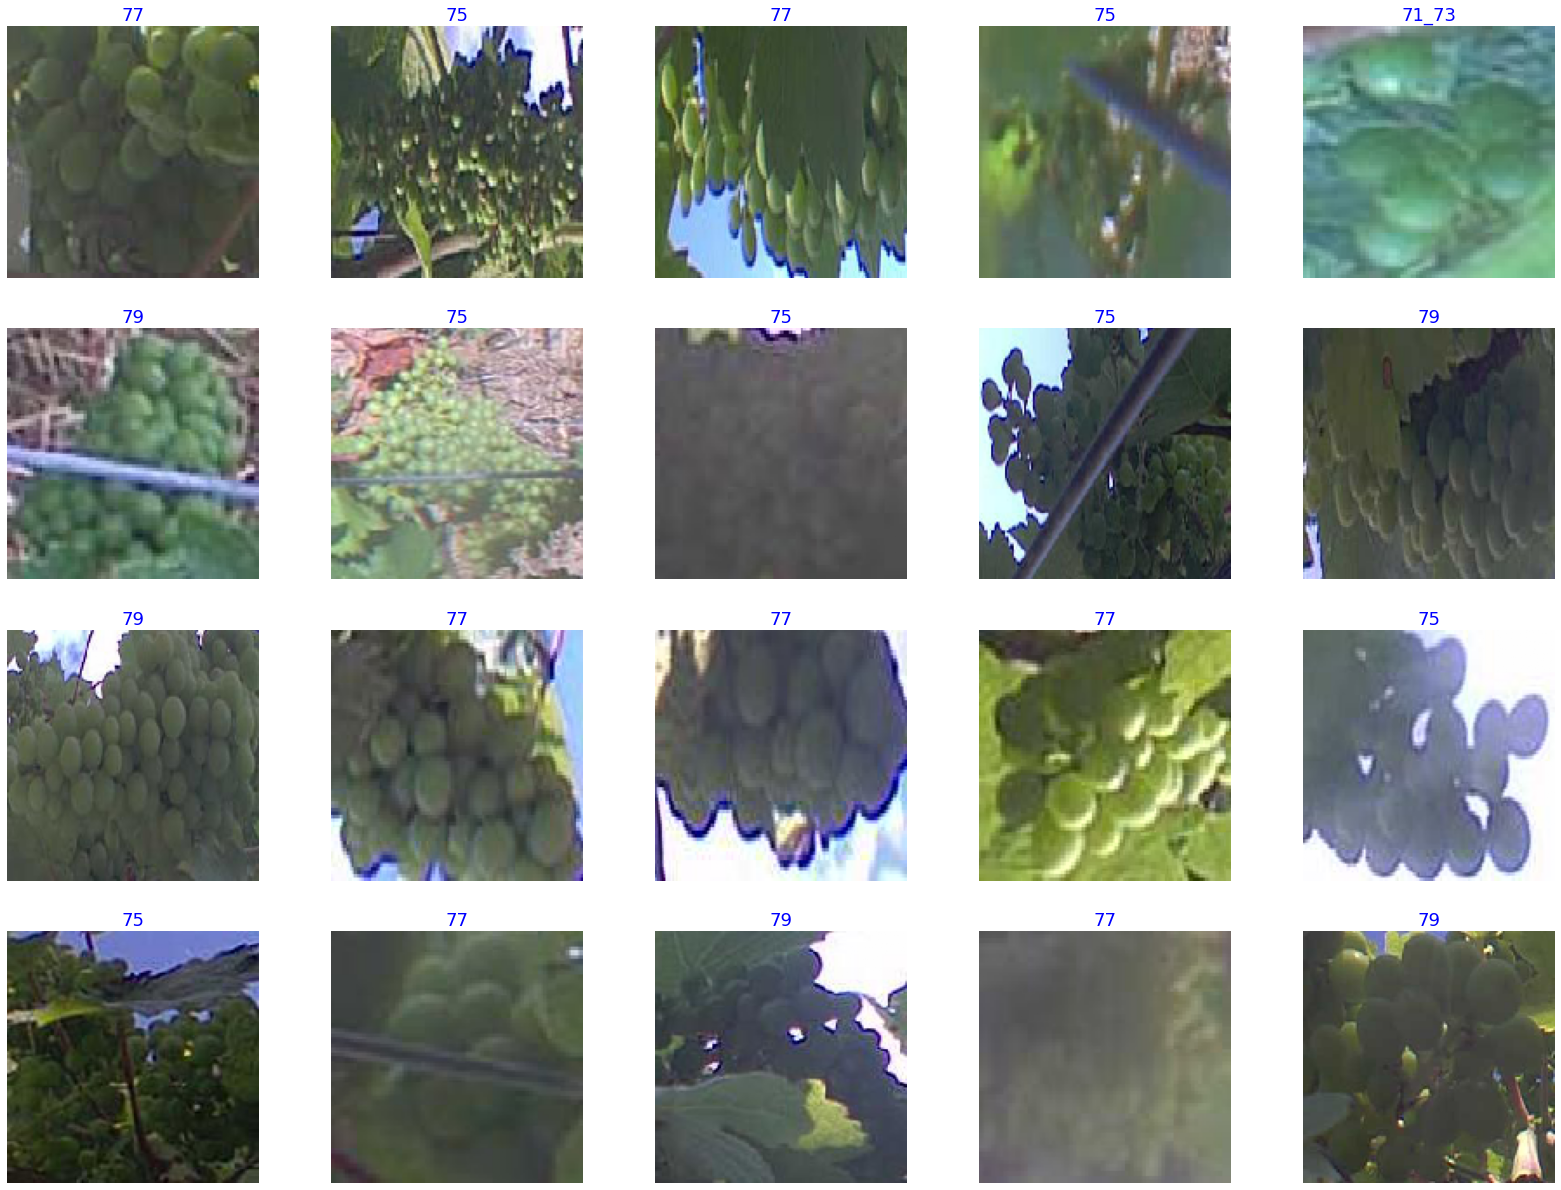

In [42]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="f1metric"></a>
# <center>Creación de función para calcular la métrica de puntuación F1.</center>

In [43]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
# <center>Creación de un modelo usando transfer learning con EfficientNetB3</center>

In [44]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

Created EfficientNet B3 model with initial learning rate set to 0.001

